# This notebook contains all the top level calls to produce the results and do the testing.

In [1]:
import numpy as np
import pandas as pd

# Importing the core functions: 

## 1. The function 'chain' runs the mcmc chain
## 2. The function 'plot_chain_behaviour' plots the results

In [5]:
from core_mcmc_functions import chain
from core_mcmc_functions import plot_chain_behaviour

In [4]:
# importing the Supernovae data

data_lcparam = pd.read_csv("lcparam_DS17f.txt", sep=" ")

# 1A :

## Reproducing Fig S18 for the case with no systematic error and a uniform prior on M. Since, there is degeneracy in the HO and M parameters, we keep M fixed at a value -19.23.

In [34]:
init_state = [.96,.2,50,-19.23] # Choosing an initial state far from the true values

max_trials = 50000 # maximum number of trials

# Defining the convergence window size. Please refer to convergence test function under core_mcmc_functions.py file
# to understand how this works. (Kyle : Can you please add why we choose a high value for the convergence window)

conv_window = 4000 

# Defining the convergence threshold (Kyle : Can you please add why we choose this as the convergence threshold value)

conv_threshold = 0.001 

# Kyle: I think we should use 0.001 as it outputs a better 2d histogram. I also wanna use the same parameter set
# for the other chains so it's nice to keep above parameters be the same.

# Running the mcmc chain

chn, rej, convergence = chain(
    data_lcparam,
    max_trials,
    conv_window,
    conv_threshold,
    start_state=init_state,
    gen_variances=None,
    prior_mode="uniform",
)

# For the chain, the default prior function used is the one defined in prior_likelihood.py file. The default
# likelihood function used are the ones defined for the case of only including statistical error. This is why
# we didn't need to input the prior and likelihood functions explicitly for this case. Please refer to the
# docstrings of the chain function to understand the details of this. 

The chain has converged to the values: [  0.35833793   0.84912015  74.66438213 -19.23      ] in 10912 trials


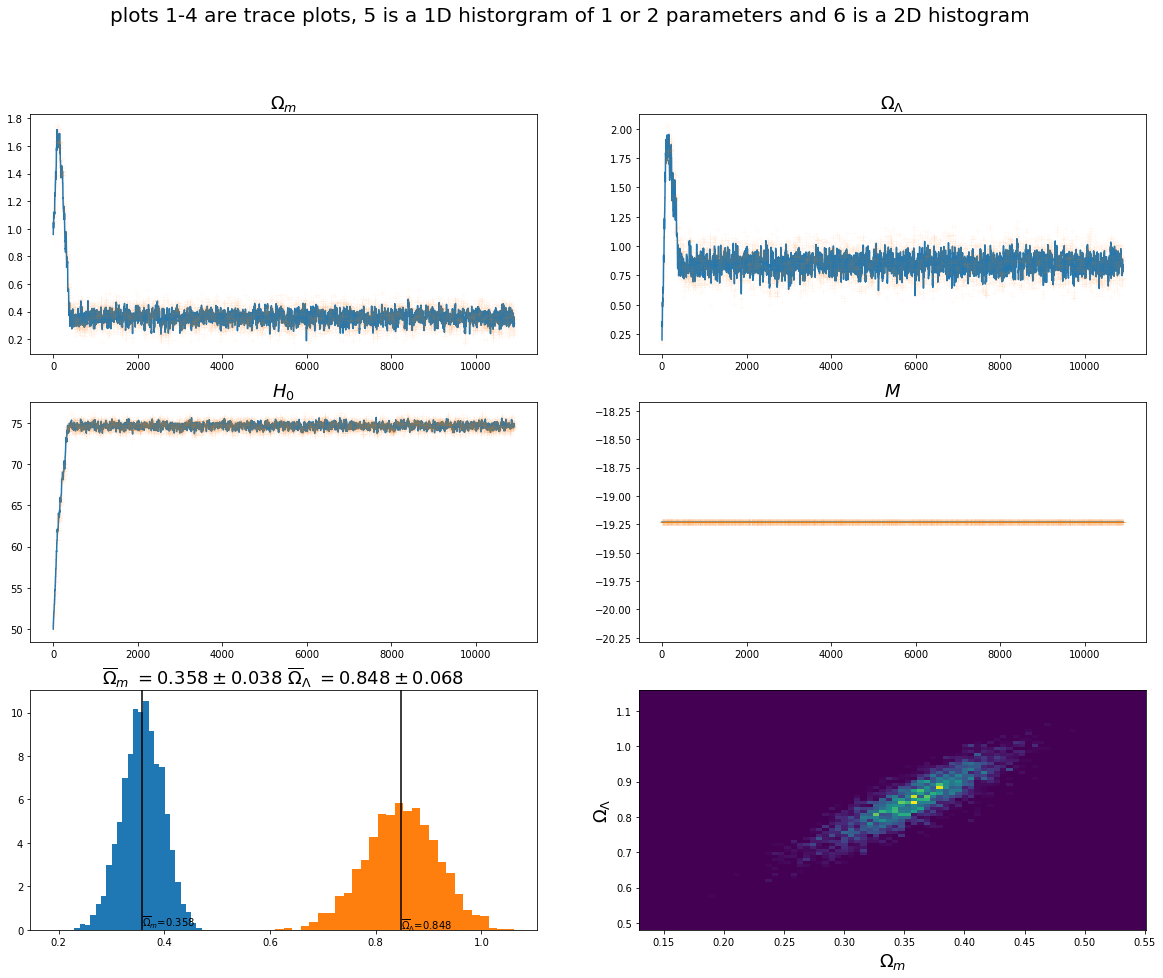

In [36]:
# plotting the results:

plot_chain_behaviour(chn, rej)

# Please refer to the plot_chain_behaviour function under core_mcmc_functions.py to understand the details of
# the plot function.

# 1B :

## Reproducing Fig S18 for the case that includes the systematic error and a uniform prior on M. Since, there is degeneracy in the HO and M parameters, we keep M fixed at a value -19.23.

In [18]:
# import systematic error data file

data_sys = pd.read_csv("sys_DS17f.txt", sep=" ")
data_sys.columns = ["sys_error"]
sys_error_data = np.reshape(pd.Series.to_numpy(data_sys.sys_error), (40, 40))

In [19]:
# Importing the likelihood function

from prior_likelihood import log_likelihood

In [20]:
# We will create a likelihood function that uses the systematic error using
# the likelihood function defined in prior_likelihood.py file. To do this we
# will make a new function that calls the likelihood function using the 
# systematic error data.

def sys_error_likelihood(params, data):
    return log_likelihood(params, data, sys_error=sys_error_data)

# Kyle: Can you please find the covariance matrix for the generating function for the case where you include the systematic error but keep the prior over M uniform?

# Can you also please add that to the core_mcmc_function and then call it here to do 1B?

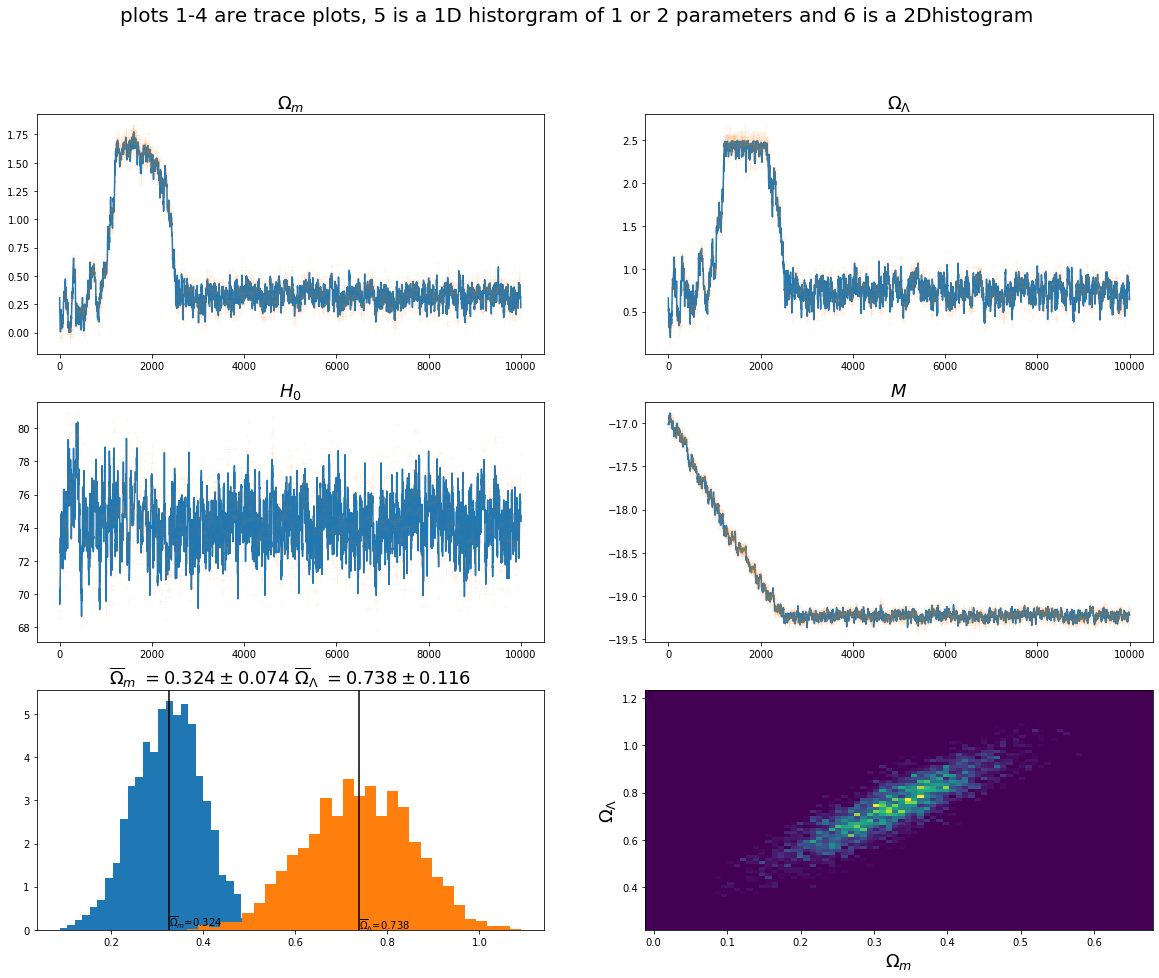

In [7]:
#plot the results:
plot_chain_behaviour(chn, rej)

# 2 :

## Calculate the posterior distribution over H_0 while including the systematic error and having a gaussian prior over M.

In [32]:
# we will start closer to the convergence values here, so it doesnt take too long to run

# Kyle: Can you please provide the reasoning here for why we wanna start closer to convergence values here?
# Include the whole low variance for M argument.

init_state2 = [.3, .9, 70, -17] # Choosing an initial state far from the true values

max_trials = 50000 # maximum number of trials

# Defining the convergence window size.

conv_window = 4000 

# Defining the convergence threshold 

conv_threshold = 0.001 

kwargs = {'gen_variances' : 'systematic', 'prior_mode' : 'M_gaussian', 'likelihood_func' : sys_error_likelihood}

chn, rej, convergence = chain(data_lcparam, max_trials, conv_window, conv_threshold, start_state=init_state2, **kwargs)              

The chain has converged to the values: [  0.31890748   0.73748618  74.18192996 -19.22938948] in 29979 trials


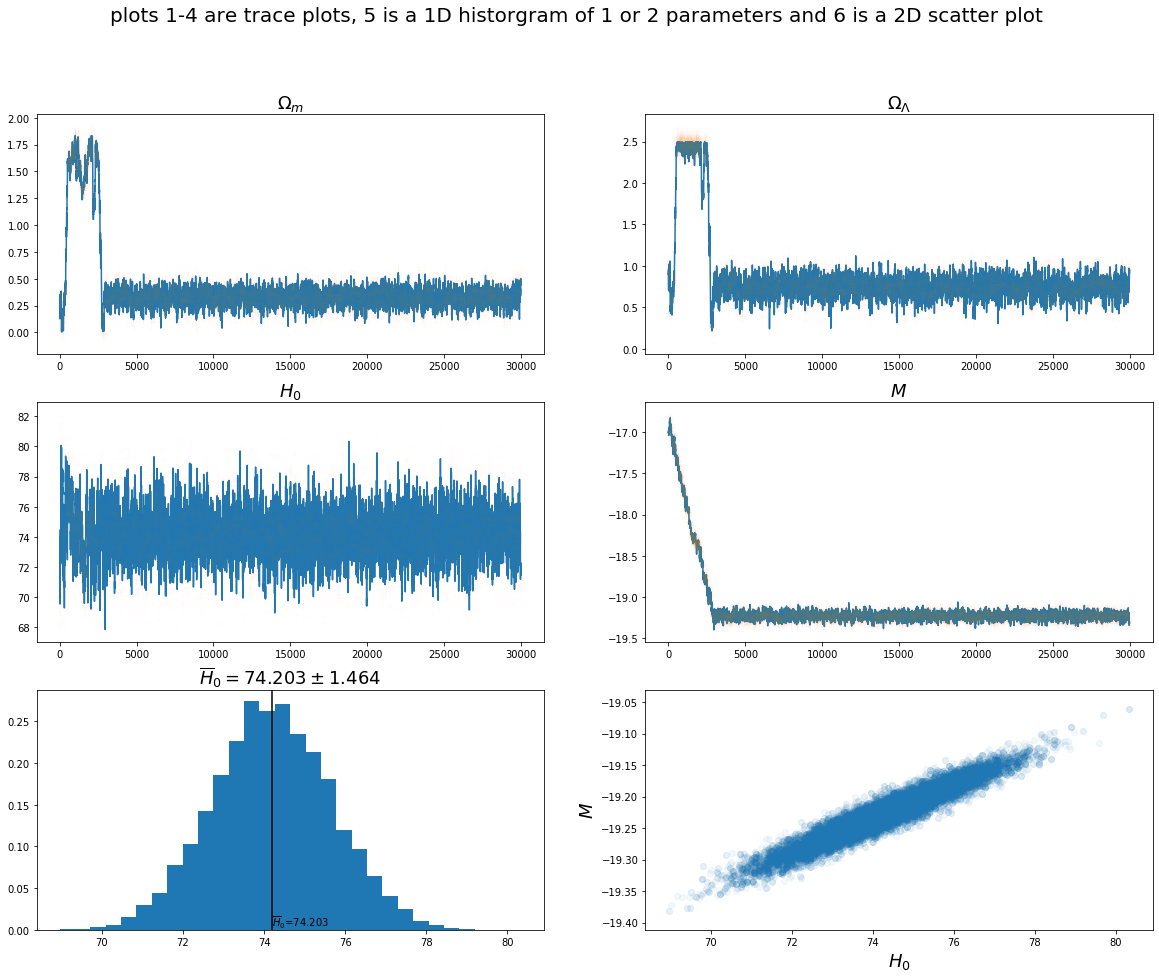

In [33]:
# All we need to do is change our plotting parameters so we get a histogram over just H_0.
# The posterior over HO will be in the 5th plot.
# Just for fun, lets play with some other options too : make the last plot a scatter plot of M and H_0.

plot_chain_behaviour(chn, rej, one_d_hist_1=2, one_d_hist_2=None, two_d_hist_1=2, two_d_hist_2=3, two_d_histogram=False)

# Testing

## Here we call all the unit test functions to test our functions.

In [25]:
#Importing all the test functions from test_function.py file.

from test_function import*

In [26]:
# Testing the apparent magnitude calculator function for the cases of Omega_K being zero, positive and negative. 

test_mag_func_omegaK_is_0()
test_mag_func_omegaK_is_neg()
test_mag_func_omegaK_is_pos()

output of the magnitude function is correct
output of the magnitude function is correct
output of the magnitude function is correct


In [28]:
# Testing the apparent magnitude calculator function for the lambda CDM model as we use this model to test
# our mcmc chain function.

test_lambda_cdm_mag_func()

output of the magnitude function for the lambda CDM model is correct


In [31]:
# Testing the log likelihood function on a fake Supernovae dataset.

log_likelihood_test_fake_data()

Log likelihood function works well on the fake data.


In [3]:
# Testing the function that performs the metropolis-hastings algorithm.

metropolis_test()

The chain has converged to the values: [  0.28426542  74.1813027  -19.23      ] in 3001 trials
mcmc chain works perfectly for the lambda cdm model


In [4]:
# Testing the mcmc chain function by comparing the result with the likelihood function

chain_test()

The chain has converged to the values: [  0.38083214   0.82        74.         -19.23      ] in 819 trials
The mcmc chain finds the correct value for Omega_M


In [5]:
# Testing the mcmc chain function by finding the correct Omega_M value for the
# lambda CDM model and comparing it with the result provided in table 8 in
# Scolnic et al 18.

mcmc_lambda_cdm_test()

'The metropolis function works well.'

# The following test is not a unit test but we found it helpful to see if our likelihood function was behaving properly or not.

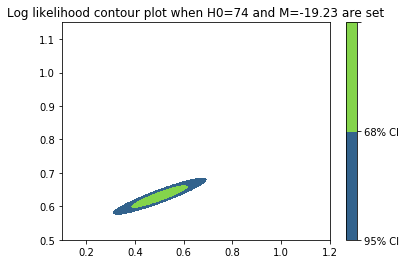

In [6]:
# This test is a little different. It is not a unit test in the sense that it doesn't end with
# an assert statement.It makes the contour plot for the log likelihood function over the 2d 
# parameter space

log_likelihood_test_contour_plot()